<a href="https://colab.research.google.com/github/vixbi/R_TextDataAnalysis/blob/main/Booking_cancellation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Галя, у нас отмена": предсказание отмены резервирования номеры в отеле

**Контекст**

Для проекта было использован датасет [Hotel Booking demand](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand?resource=download&select=hotel_bookings.csv), доступный на платформе Kaggle. Этот набор данных представляет собой предобработанную версию оригинального датасета, описанного в \[[Antonio et al., 2019](https://www.sciencedirect.com/science/article/pii/S2352340918315191)\]. Первоначальные данные были получены авторами с помощью SQL-запроса к системе PMS (Property Management System), которая используется отелями для управления бронированиями.

Как отмечают авторы оригинального датасета [Antonio et al., 2019], отели сталкиваются с рядом критических проблем при планировании бизнес-стратегии, связанных с неопределенностью (а порой с непредсказуемостью) поведения гостей. Вот самые критичные моменты:
1. Отмены бронирований в последний момент, что приводит к:
 * потере доходов: освободившиеся номера не успевают занять новые гости, так как они уже выбрали другие варианты
 * простою ресурсов: отель теряет прибыль из-за неоптимальной загрузки (номера, за которые никто не платит, продолжают отапливаться и содержаться в чистоте за счет труда горничных; в итоге новой прибыли нет, а накопленные ранее ресурсы продолжают тратиться)
2. Изменение условий бронирования перед заездом (изменение числа гостей в номере, добавление или отмена дополнительные услуг), что создает:
 * логистические сложности (например, нехватку мест в ресторане при резком росте числа завтраков)
 * финансовые риски (непредсказуемость затрат на обслуживание).

Основная задача проекта, таким образом, разработать модель для hotel demand forecasting (прогнозирование спроса на номера). Продуктивно работающая модель машинного обучения позволит отелям:
* оценивать риски пере- или недобронирования
* оптимизировать ценообразование
* задавать условия наличия/отсутствия предоплаты в зависимости от конкретных факторов
* повышать эффективность работы за счет прогнозирования загрузки отелей

In [ ]:
!pip install catboost optuna plotly

In [ ]:
# импорт необходимых библиотек
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, \
balanced_accuracy_score
from sklearn.pipeline import make_pipeline

from yellowbrick.model_selection import FeatureImportances

from lightgbm import LGBMClassifier, cv
import catboost

import optuna

import numpy as np

import pickle

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly

In [ ]:
random_num = 9

## 1. Загрузка данных, EDA

**Представленные переменные**

В датасете представлены следующие переменные:

**Таргет**: `is_canceled` - была ли бронь отменена или нет

**Фичи**:

* **Числовые:**
 * *Непрерывные:*
   1. `adr`: Average Daily Rate, показатель, который показывает, сколько в среднем гость отдает за номер; непрерывная
 * *Дискретные:*
   2. `adults`: количество взрослых, указанных в брони
   3.`babies`: количество малышей, указанных в брони
   4. `booking_changes`: количество изменений, которые сделал в брони гость (количество гостей, дата прибытия и т.п .)
   5. `days_in_waiting_list`: количество дней, которое гость провел в листе ожидания (то есть кол-во дней от даты резерва до даты подтверждения от отеля)
   6. `children`: количество детей, указанных в брони
   7. `lead_time`: количество дней, прошедших с дня брони до дня предполагаемого заселения
   8. `stays_in_weekend_nights`: количество ночей на выходных, которые гости проводили/собирались проводить в отеле
   9. `stays_in_week_nights`: количество ночей в будние дни, которые гости проводили/собирались проводить в отеле
   10. `total_of_special_requests`: количество специальных запросов от гостей (тип кровати, верхний этаж и т.п.)
   11. `previous_bookings_not_canceled`: количеств раз перед текущим бронированием, когда другое бронирование не было отменено
   12. `previous_cancellations`: количеств раз перед текущим бронированием, когда другое бронирование было отменено
   13. `required_car_parking_spaces`: количество парковочных мест, запрошенных клиентом
* **Качественные:**
 * *Бинарные*:
   14. `is_repeated_guest`: был ли гость до этого в отеле
   15. `hotel`: категориальная: тип отеля (resort/city, про это см. пункт 1.1)
 * *Категориальные*:
   16. `agent`: ID агенства, которое делало резервирование
   17. `arrival_date_year`: год, за который собраны данные (2015-2017)
   18. `arrival_date_month`: месяц брони
   19. `arrival_date_week_number`: номер недели в году
   20. `assigned_room_type`: тип комнаты, в которую гостя заселили
   21. `arrival_date_day_of_month`: первый день брони
   22. `company`: ID компании/сущности, которая сделала букинг и/или оплатила его
   23. `country`: страна, гражданином которой гость является
   24. `customer_type`: тип клиента (Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking)
   25. `deposit_type`: вносился ли какой-то депозит и если да, то какой (No Deposit - не вносился; Refundable - если депозит был возвратным и был меньше стоимости за все; non-refund - депозит был внесен в полном размере и затем не возвращался)
   26. `distribution_channel`: канал сбыта (TA - “Travel Agents”, “TO” - “Tour Operators”)
   27. `meal`: тип питания (Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner)
   28. `market_segment` - сегмент рынка (TA/TO)
   29. `reserved_room_type`: тип комнаты, которую гость резервировал (может отличаться от `assigned_room_type` по разным причинам)
   30. `reservation_status`: статус гостя (выселился, не въехал и т. п.)
   31. `reservation_status_date`: дата последнего статуса

In [ ]:
# загрузим наш датасет и посмотрим на типы данных;
# как можно увидеть, они в целом соответствуют тому, что бы мы ожидали там увидеть

sharing_url = "https://drive.google.com/file/d/1G_TRC9hQhTbnTrirs0H8bPwoz1q7fzeT/view?usp=drive_link"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]
hotel_dataset_file = pd.read_csv(download_url)
hotel_dataset_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## 1.1. Особенности датасета

Перед визуализацией распределения таргетов заметим несколько особенностей датасета относительно нашей задачи:
1. Оригинальный датасет на самом деле является комбинацией из двух других
2. Нам необходимо создать модель, использующую в качестве предикторов только те данные, которые доступны до момента отмены или подтверждения брони, исключив показатели, не соответствующие этому условию или дублирующие информацию о таргете. Иначе говоря, надо исключить:
 * `assigned_room_type`: если гость отменил бронирование, то мы не знаем, были ли несовпадения в том, какой номер он бронировал, и тот, в который его в итоге заселили
 * `reservation_status` и `reservation_status_date`: эти данные можно использовать для анализа других составляющих (например, если гость выселился раньше, чем планировал, то интересно посмотреть, что на это могло повлиять)
3. Есть несколько фичей по времени: `arrival_date_year`, `arrival_date_month`, `arrival_date_week_number`, `arrival_date_day_of_month`. При feature-engeneering после обучения бейзлайна надо бы подумать, что с ними делать.
4. В оригинальной работе этот датасет - это на самом деле два датасета: датасет по resort hotel и датасет по city hotel. В отельном бизнесе эти два вида несколько отличаются друг от друга: например, в resort hotel будет больше всяких facilities типа аквапарка и прочего, и туда в большинстве своем приезжают именно за отдыхом (причем, как правило, на морских/горнолыжных курортах). В свою очередь, city hotel - это именно про отели внутри города, и тут больше процент людей, останавливающихся там на время командировок (или туристов с другими запросами). С т.з. бизнеса, эти задачи по-хорошему должны решаться двумя отдельными моделями. Я решила поступить следующим образом: обучать три типа моделей - resort_subset, city_subset и hotel_subset, чтобы потом сравнить результаты (остальные предикторы у них так или иначе одинаковые.

In [ ]:
# посмотрим также на наличие (отсутствие) пропущенных значений
hotel_isna = dict(hotel_dataset_file.isna().sum())
for key in hotel_dataset_file:
    if hotel_isna[key] != 0:
        print(key, hotel_isna[key])

children 4
country 488
agent 16340
company 112593


У нас добавилось еще несколько фичей, в которых пропущены значения. Для двух (`country` и `children`) количество пропущенных значений не настолько значимое; давайте для `children` укажем 0 везде, где NA, а строки со странами в целом опустим.

Сложнее ситуация с `agent` и `company`: там количество строк, где есть пропущенные значения, значительно больше. Это может быть связано с тем, что бронь не всегда происходит через какого-то агента/компанию, зачастую гость делает ее напрямую. Можно было бы целиком убрать эти колонки, но мы сделаем немного иначе: добавим к ним новый лейбл 0, который указывает как раз на категорию гостей, которые не использовали company/agent. Проверим, что у нас нет 0 в изначальных лейблах:

In [ ]:
print(sum(hotel_dataset_file.agent == 0))
print(sum(hotel_dataset_file.company == 0))

0
0


Отлично! Тогда последние штрихи перед визуализацией

In [ ]:
# исключаем 3 указанные колонки
hotel_dataset = hotel_dataset_file.drop(columns=['reservation_status', 'reservation_status_date', 'assigned_room_type'])

# исключаем строки, где пропущены значения по странам
hotel_dataset = hotel_dataset.dropna(subset=['country'])

# заполняем оставшееся нулями
hotel_dataset.fillna({'children': 0, 'company': 0, 'agent': 0}, inplace=True)


In [ ]:
# снова проверяем наличие пропущенных значений
hotel_dataset.isna().values.any()

np.False_

In [ ]:
len(hotel_dataset)

118902

In [ ]:
# создаем еще два датасета, с которыми дальше будем работать; из двух уберем колонку с типом отеля
resort_subset = hotel_dataset[hotel_dataset.hotel == 'Resort Hotel'].drop(columns=['hotel'])
city_subset = hotel_dataset[hotel_dataset.hotel == 'City Hotel'].drop(columns=['hotel'])

In [ ]:
# проверим у них пропущенные значения также (ну мало ли...)
print(resort_subset.isna().values.any())
print(city_subset.isna().values.any())

False
False


Давайте разберемся с датами. Сейчас они представлены у нас в четырех отдельных переменных. Кажется, для дальнейшей работы есть смысл привести их к формату 'yyyy-mm-dd'. Сделаем это!

In [ ]:
month_map = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}

hotel_dataset['arrival_date_month_num'] = hotel_dataset['arrival_date_month'].map(month_map)

hotel_dataset['date'] = hotel_dataset['arrival_date_year'].astype(str) + '-' + \
hotel_dataset['arrival_date_month_num'].astype(str).str.zfill(2) + '-' + hotel_dataset['arrival_date_day_of_month'].astype(str).str.zfill(2)

hotel_dataset.date

,date
0,2015-07-01
1,2015-07-01
2,2015-07-01
3,2015-07-01
4,2015-07-01
...,...
119385,2017-08-30
119386,2017-08-31
119387,2017-08-31
119388,2017-08-31


## 1.2. Визуализации для EDA: распределение таргета и корреляционная матрица

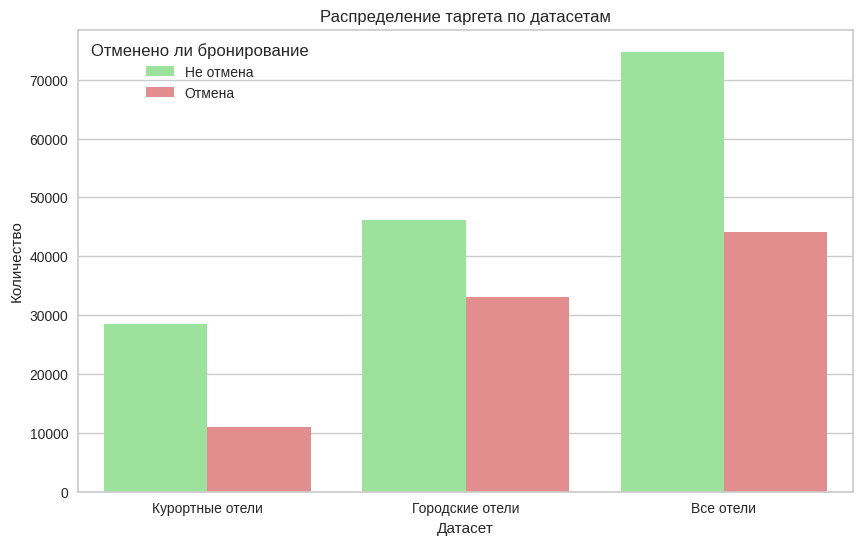

In [ ]:
resort_subset['dataset'] = 'Курортные отели'
city_subset['dataset'] = 'Городские отели'
hotel_dataset['dataset'] = 'Все отели'
combined = pd.concat([resort_subset, city_subset, hotel_dataset])

plt.figure(figsize=(10, 6))
sns.countplot(data=combined, x='dataset', hue='is_canceled',
              palette={0: 'lightgreen', 1: 'lightcoral'})
plt.title('Распределение таргета по датасетам')
plt.xlabel('Датасет')
plt.ylabel('Количество')
plt.legend(title='Отменено ли бронирование', labels=['Не отмена', 'Отмена'])
plt.show()

Давайте еще посмотрим на распределение таргета по годам. Как мы позже узнаем, у нас есть не все данные за 2015 и 2017 год.

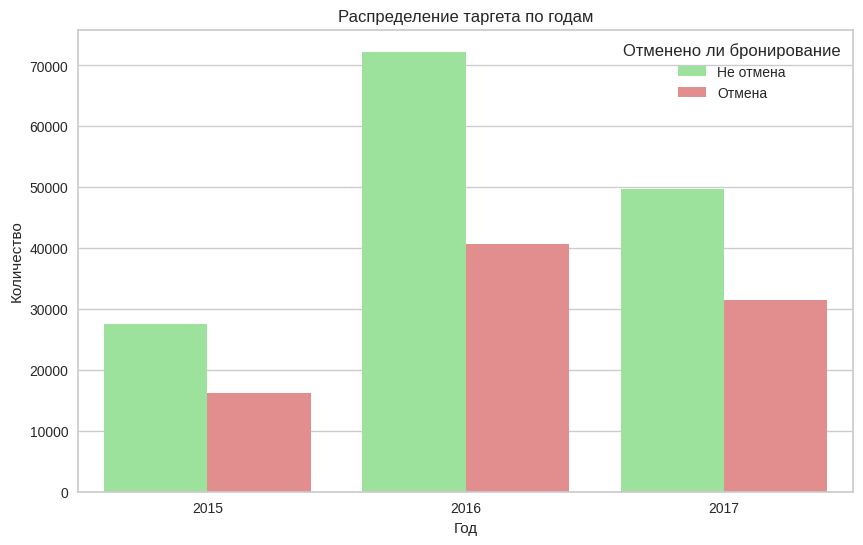

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=combined, x='arrival_date_year', hue='is_canceled',
              palette={0: 'lightgreen', 1: 'lightcoral'})
plt.title('Распределение таргета по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.legend(title='Отменено ли бронирование', labels=['Не отмена', 'Отмена'])
plt.show()

Как можно увидеть из графика, таргет не очень сбалансирован для всех трех датасетов. Тем не менее, было решено не брать идеально сбалансированные данные, поскольку это отображает распределение переменной в реальном мире: чаще всего брони подтверждают, а не отменяют.

In [ ]:
# тут я изначально хотела сделать графики с линией по номерам недели для каждого года,
# но столкнулась со следующей ситуацией:
cancel_rate = hotel_dataset.groupby(['arrival_date_week_number', 'arrival_date_year'])['is_canceled'].mean().unstack('arrival_date_year')
cancel_rate

arrival_date_year,2015,2016,2017
arrival_date_week_number,,,
1,NaN,0.331858,0.339853
2,NaN,0.189873,0.389976
3,NaN,0.180365,0.296984
4,NaN,0.287744,0.379691
5,NaN,0.290553,0.321472
6,NaN,0.214706,0.296526
7,NaN,0.310710,0.339410
8,NaN,0.392495,0.332786
9,NaN,0.349142,0.339013


Изначально я планировала обучаться на 2015 и 2016 годах, а 2017 оставить на тест (out-of-time-approach), но я столкнулась с ситуацией, что у меня есть полные данные за 2016 год и нет данных за первую половину 2015 и вторую половину 2017. Учтем это и пока визуализируемся на данных только за 2016 год.

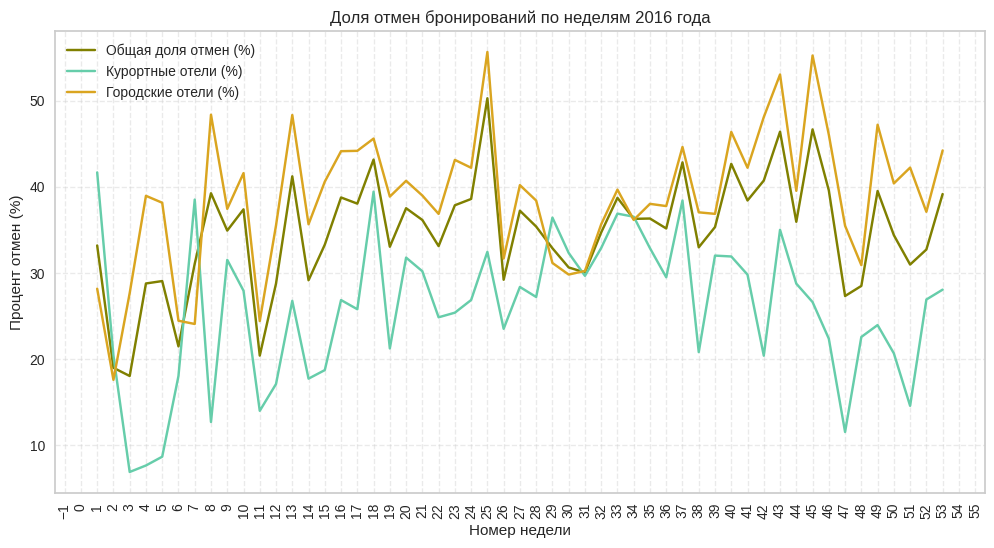

In [ ]:
cancel_rate = hotel_dataset[hotel_dataset.arrival_date_year == 2016].groupby('arrival_date_week_number')['is_canceled'].mean() * 100
cancel_rate_rh = resort_subset[resort_subset.arrival_date_year == 2016].groupby('arrival_date_week_number')['is_canceled'].mean() * 100
cancel_rate_ch = city_subset[city_subset.arrival_date_year == 2016].groupby('arrival_date_week_number')['is_canceled'].mean() * 100


plt.figure(figsize=(12, 6))

cancel_rate.plot(color='olive', label='Общая доля отмен (%)')
cancel_rate_rh.plot(color='mediumaquamarine', label='Курортные отели (%)')
cancel_rate_ch.plot(color='goldenrod', label='Городские отели (%)')

plt.title('Доля отмен бронирований по неделям 2016 года')
plt.ylabel('Процент отмен (%)')
plt.xlabel('Номер недели')

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(fontsize=10, rotation=90)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()

Для всех трех типов отелей можно увидеть похожие паттерны: на ~25 неделе (июнь) происходит резкий рост числа отмен бронирований во всех трех типах отелей. Такая же ситуация наблюдается в 43-46 неделю месяца.

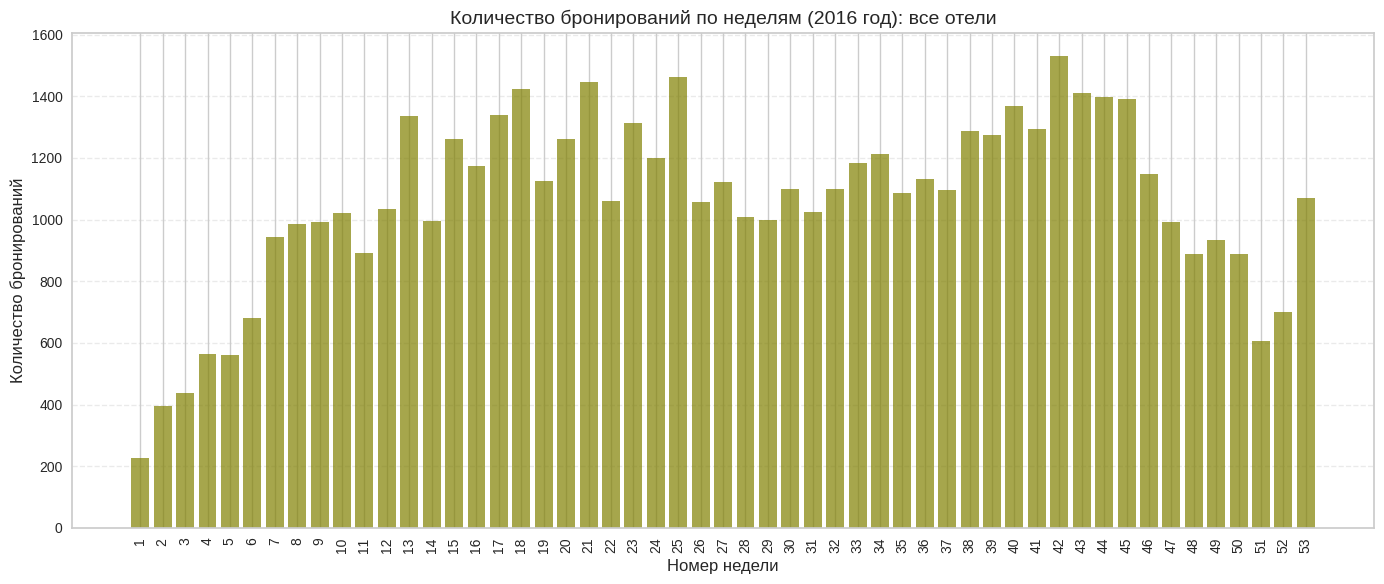

In [ ]:
# кажется, временной слот у нас достаточно важен; давайте посмотрим на распределение данных в зависимости от недели
weekly_bookings = hotel_dataset[hotel_dataset['arrival_date_year'] == 2016].groupby('arrival_date_week_number').size()
weekly_bookings_rh = resort_subset[resort_subset['arrival_date_year'] == 2016].groupby('arrival_date_week_number').size()
weekly_bookings_ch = city_subset[city_subset['arrival_date_year'] == 2016].groupby('arrival_date_week_number').size()

plt.figure(figsize=(14, 6))

plt.bar(weekly_bookings.index, weekly_bookings, color='olive', alpha=0.7)

plt.title('Количество бронирований по неделям (2016 год): все отели', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество бронирований', fontsize=12)
plt.xticks(weekly_bookings.index, rotation=90, fontsize=10)  # Номера недель по оси X
plt.grid(axis='y', linestyle='--', alpha=0.4)  # Сетка только по оси Y
plt.tight_layout()
plt.show()

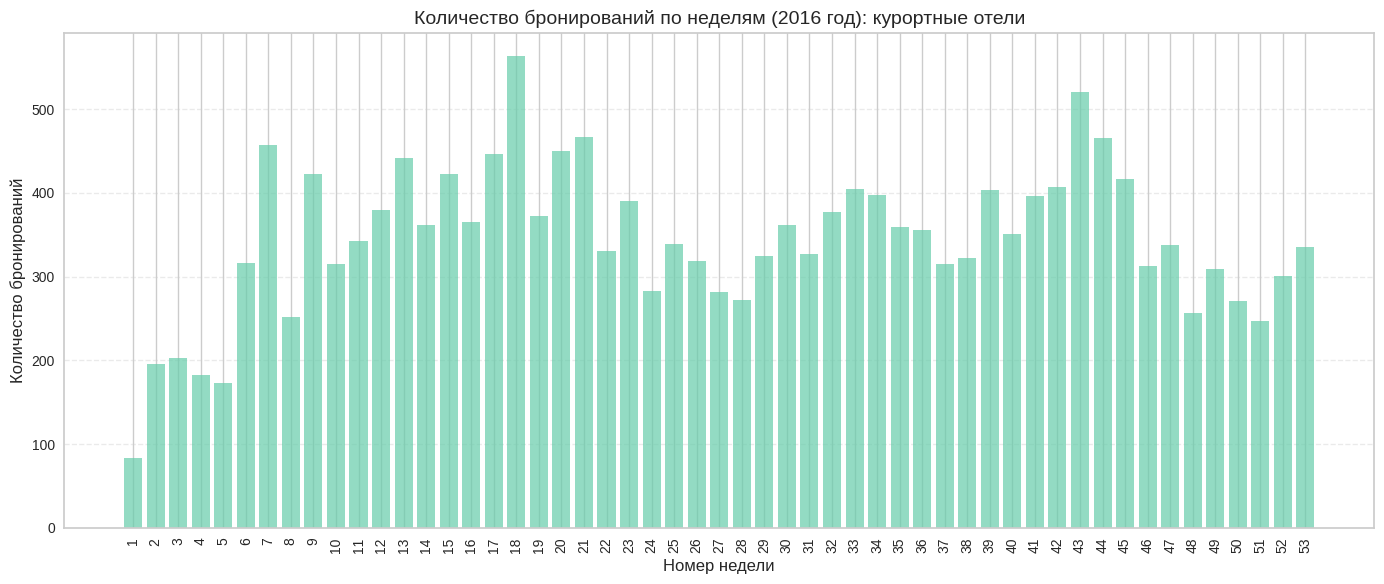

In [ ]:
plt.figure(figsize=(14, 6))

plt.bar(weekly_bookings_rh.index, weekly_bookings_rh, color='mediumaquamarine', alpha=0.7)

plt.title('Количество бронирований по неделям (2016 год): курортные отели', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество бронирований', fontsize=12)
plt.xticks(weekly_bookings_rh.index, rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

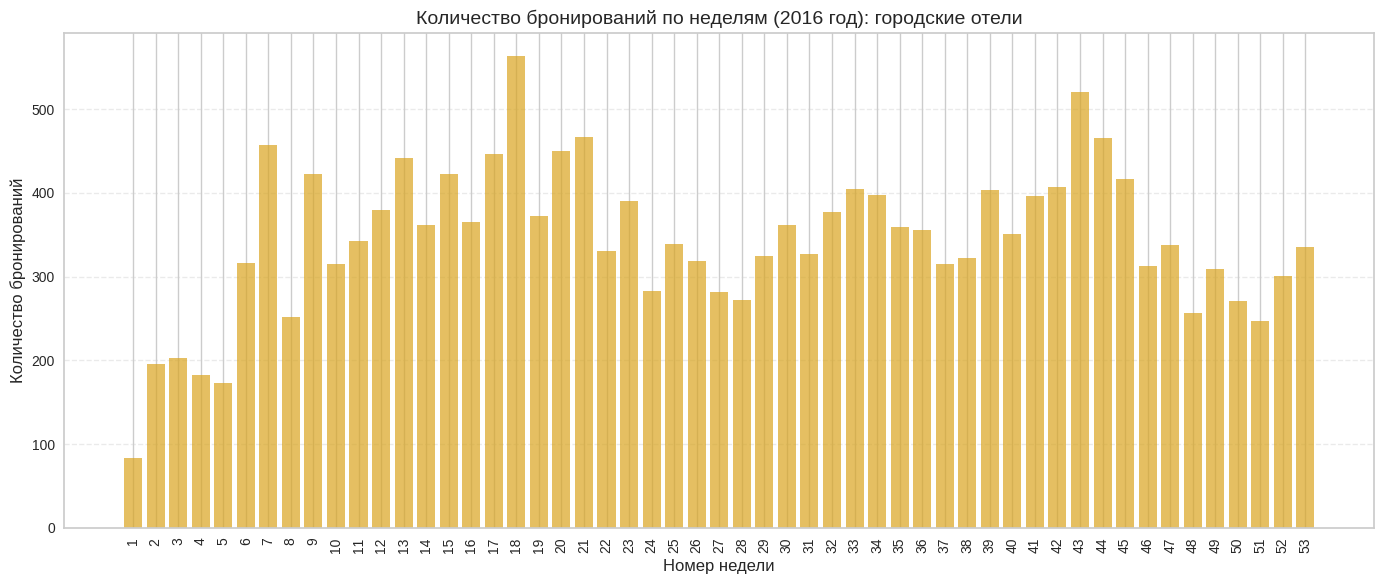

In [ ]:
plt.figure(figsize=(14, 6))

plt.bar(weekly_bookings_rh.index, weekly_bookings_rh, color='goldenrod', alpha=0.7)

plt.title('Количество бронирований по неделям (2016 год): городские отели', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество бронирований', fontsize=12)
plt.xticks(weekly_bookings_rh.index, rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Как можно увидеть из трех графиков выше, распределение количества бронирований по месяцам по всем трем датасетам примерно одинаково.

In [ ]:
# посмотрим на матрицы корреляции для числовых признаков; для этого выделим их
# в отдельную переменную

cat_features = [
    'is_repeated_guest',
    'hotel',
    'agent',
    'company',
    'country',
    'customer_type',
    'deposit_type',
    'distribution_channel',
    'meal',
    'market_segment',
    'reserved_room_type',
    'arrival_date_week_number']


to_drop = ['arrival_date_year', 'arrival_date_month',
           'arrival_date_day_of_month', 'date', 'dataset',
           'arrival_date_month_num']

numeric_features = hotel_dataset.columns.drop(to_drop + cat_features).tolist()

numeric_hd = hotel_dataset[numeric_features]

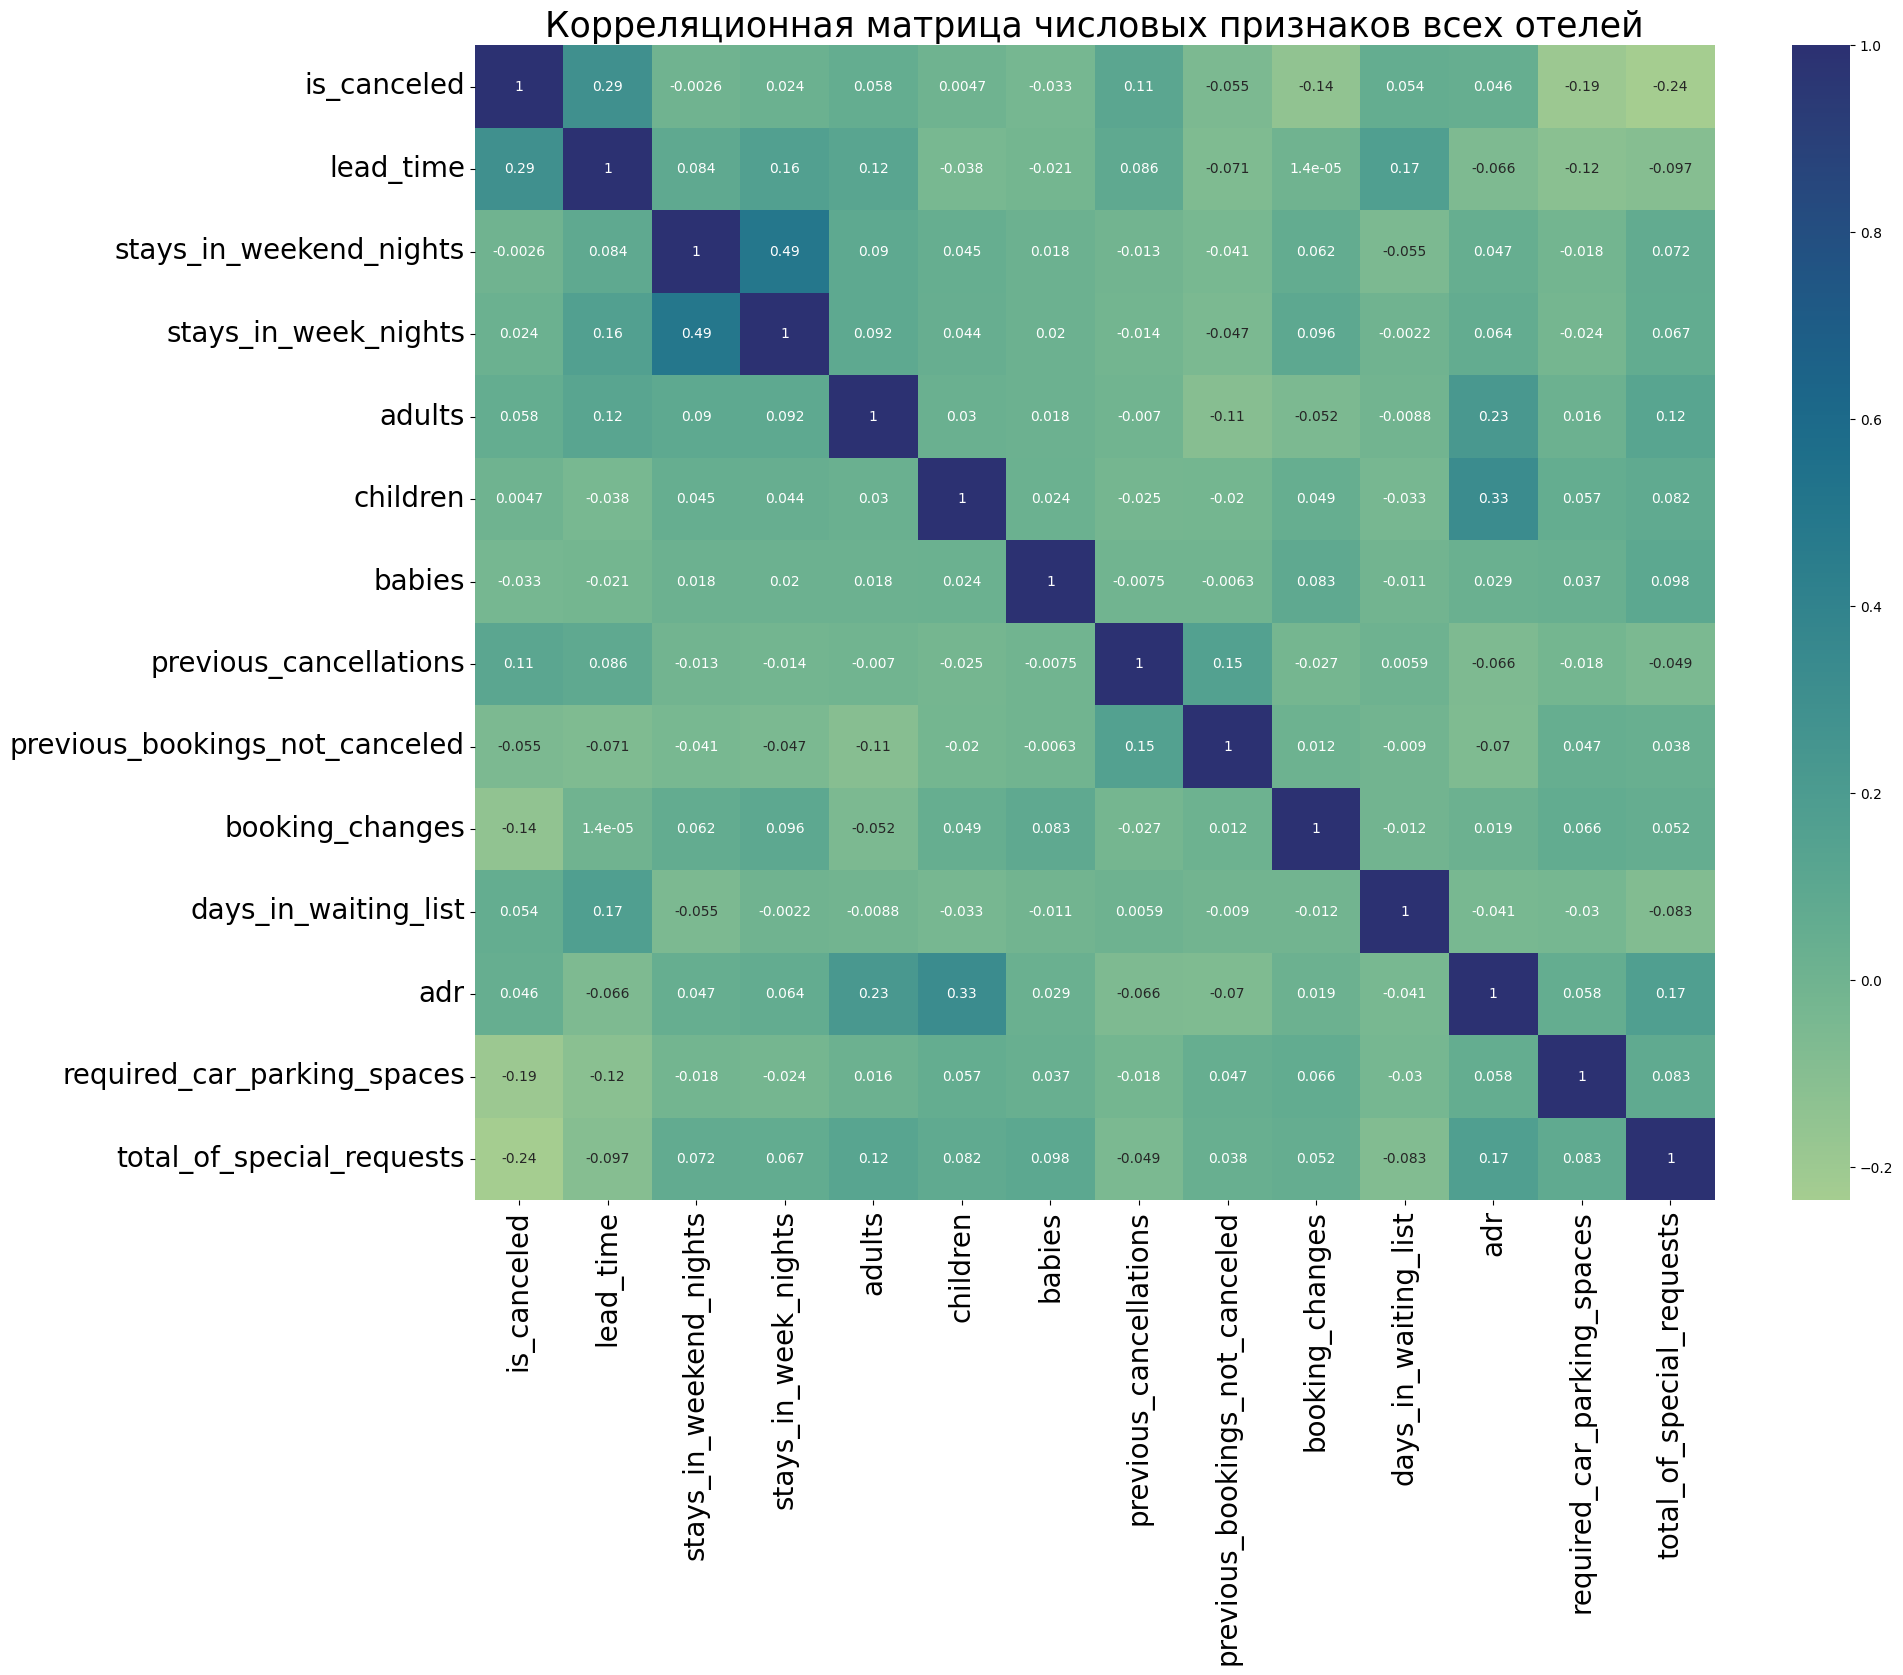

In [ ]:
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(numeric_hd.corr(), annot=True,
            cmap='crest')
plt.title('Корреляционная матрица числовых признаков всех отелей', fontsize=25)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)
plt.show()

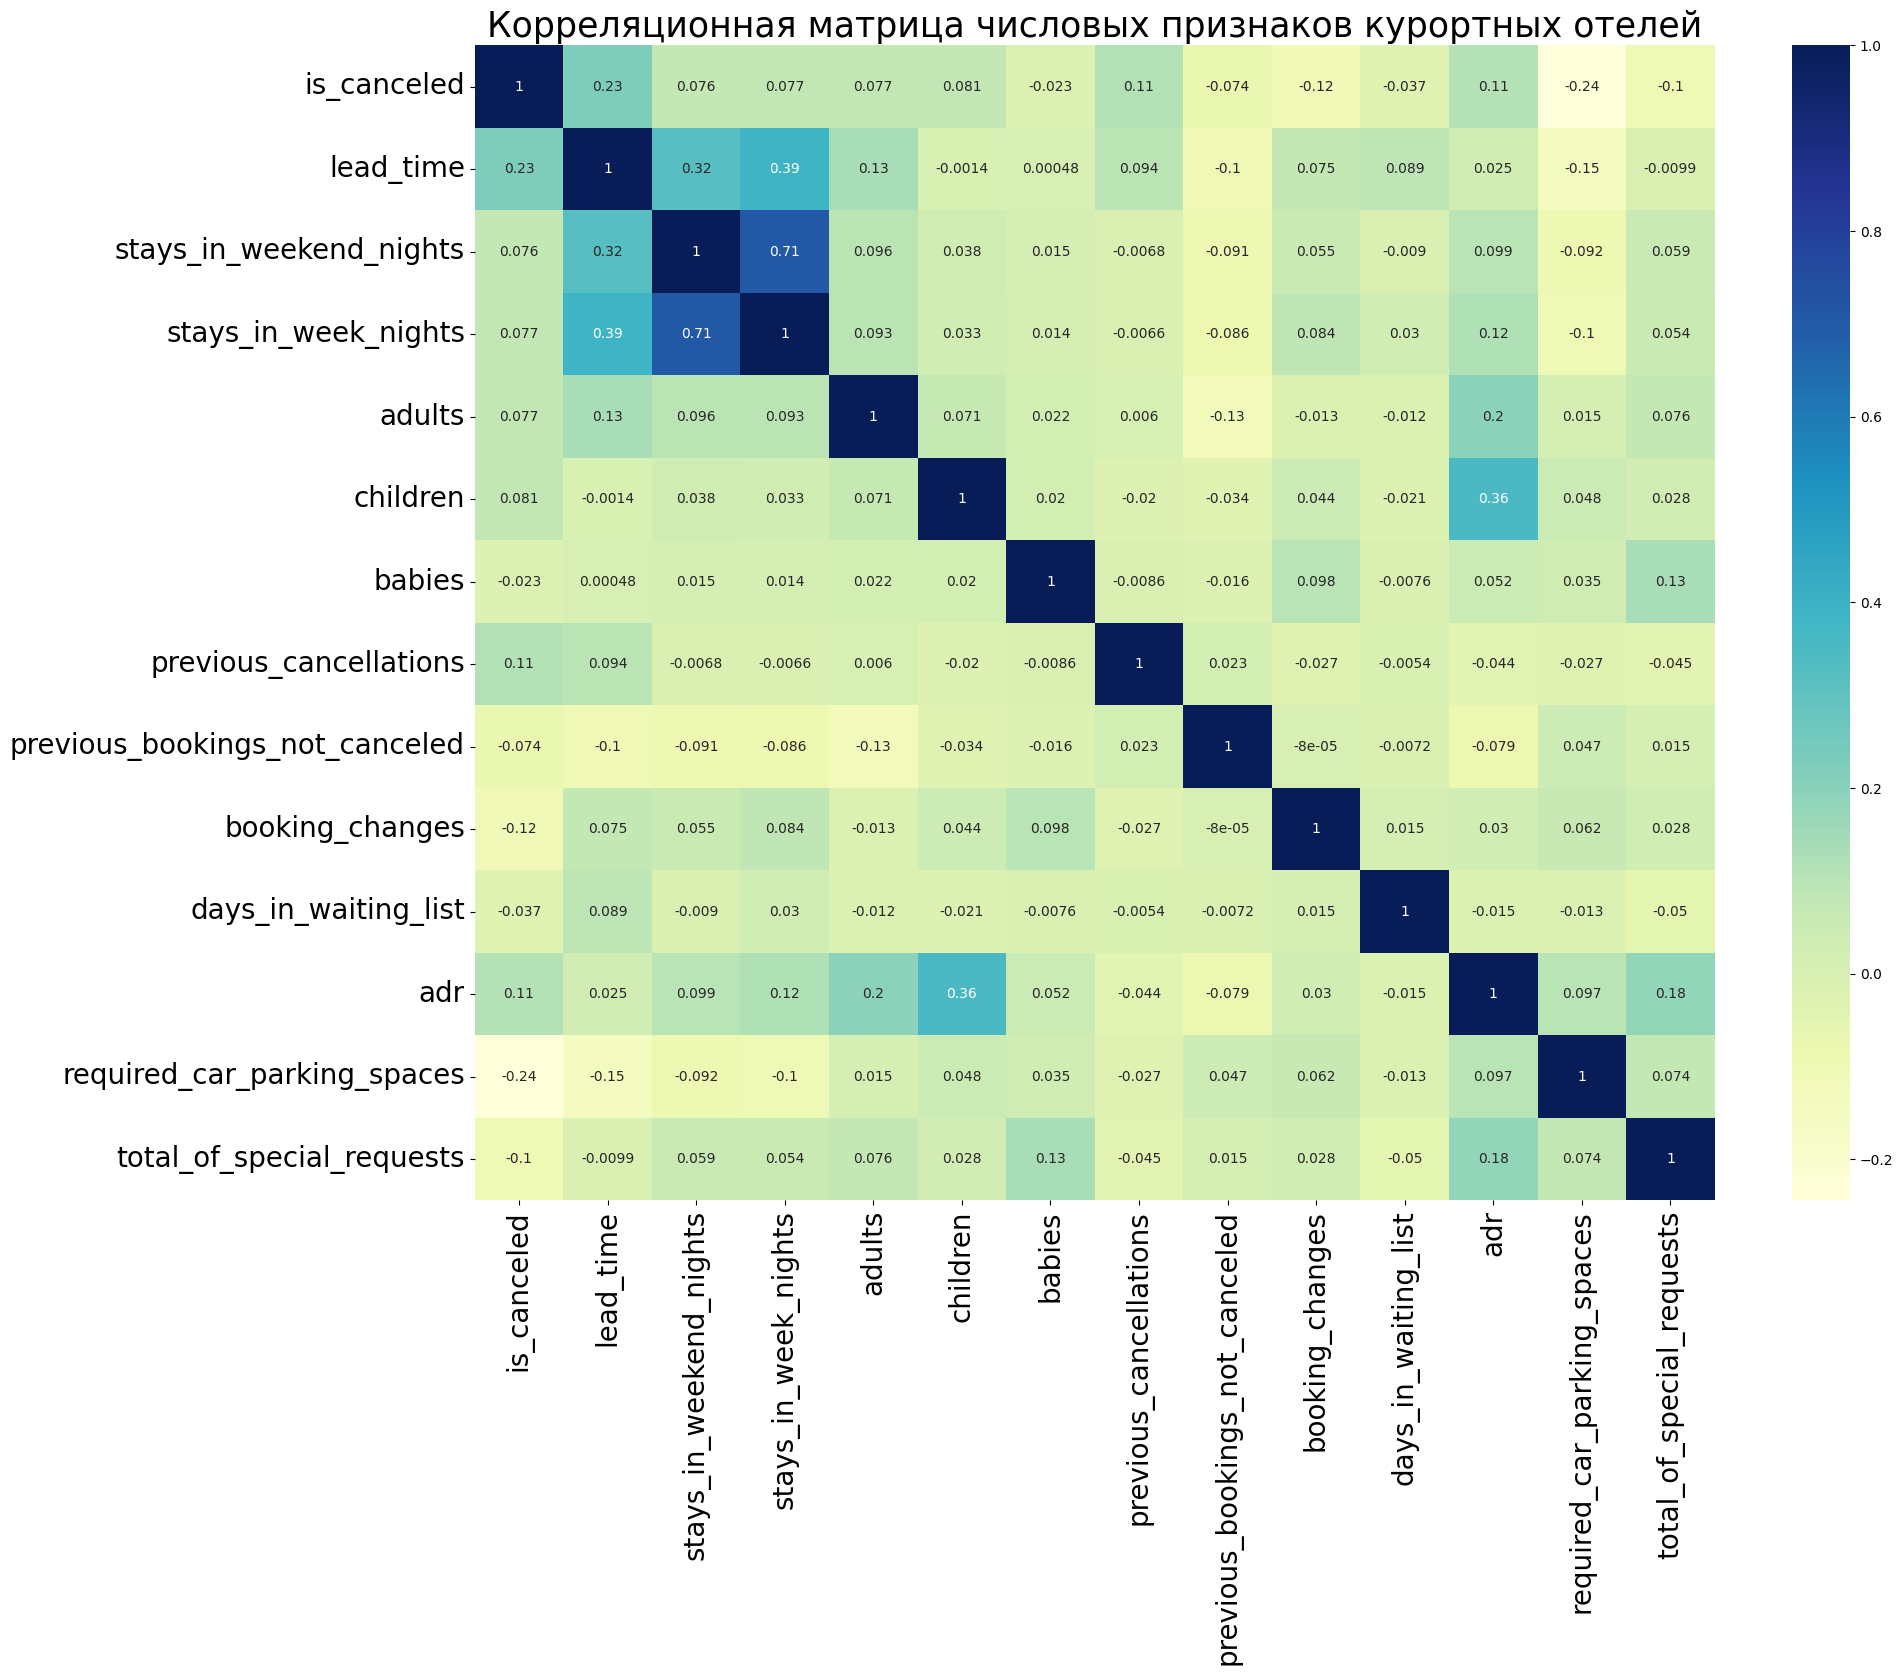

In [ ]:
numeric_resort = resort_subset[numeric_features]
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(numeric_resort.corr(), annot=True,
                      cmap='YlGnBu')
plt.title('Корреляционная матрица числовых признаков курортных отелей', fontsize=25)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)
plt.show()

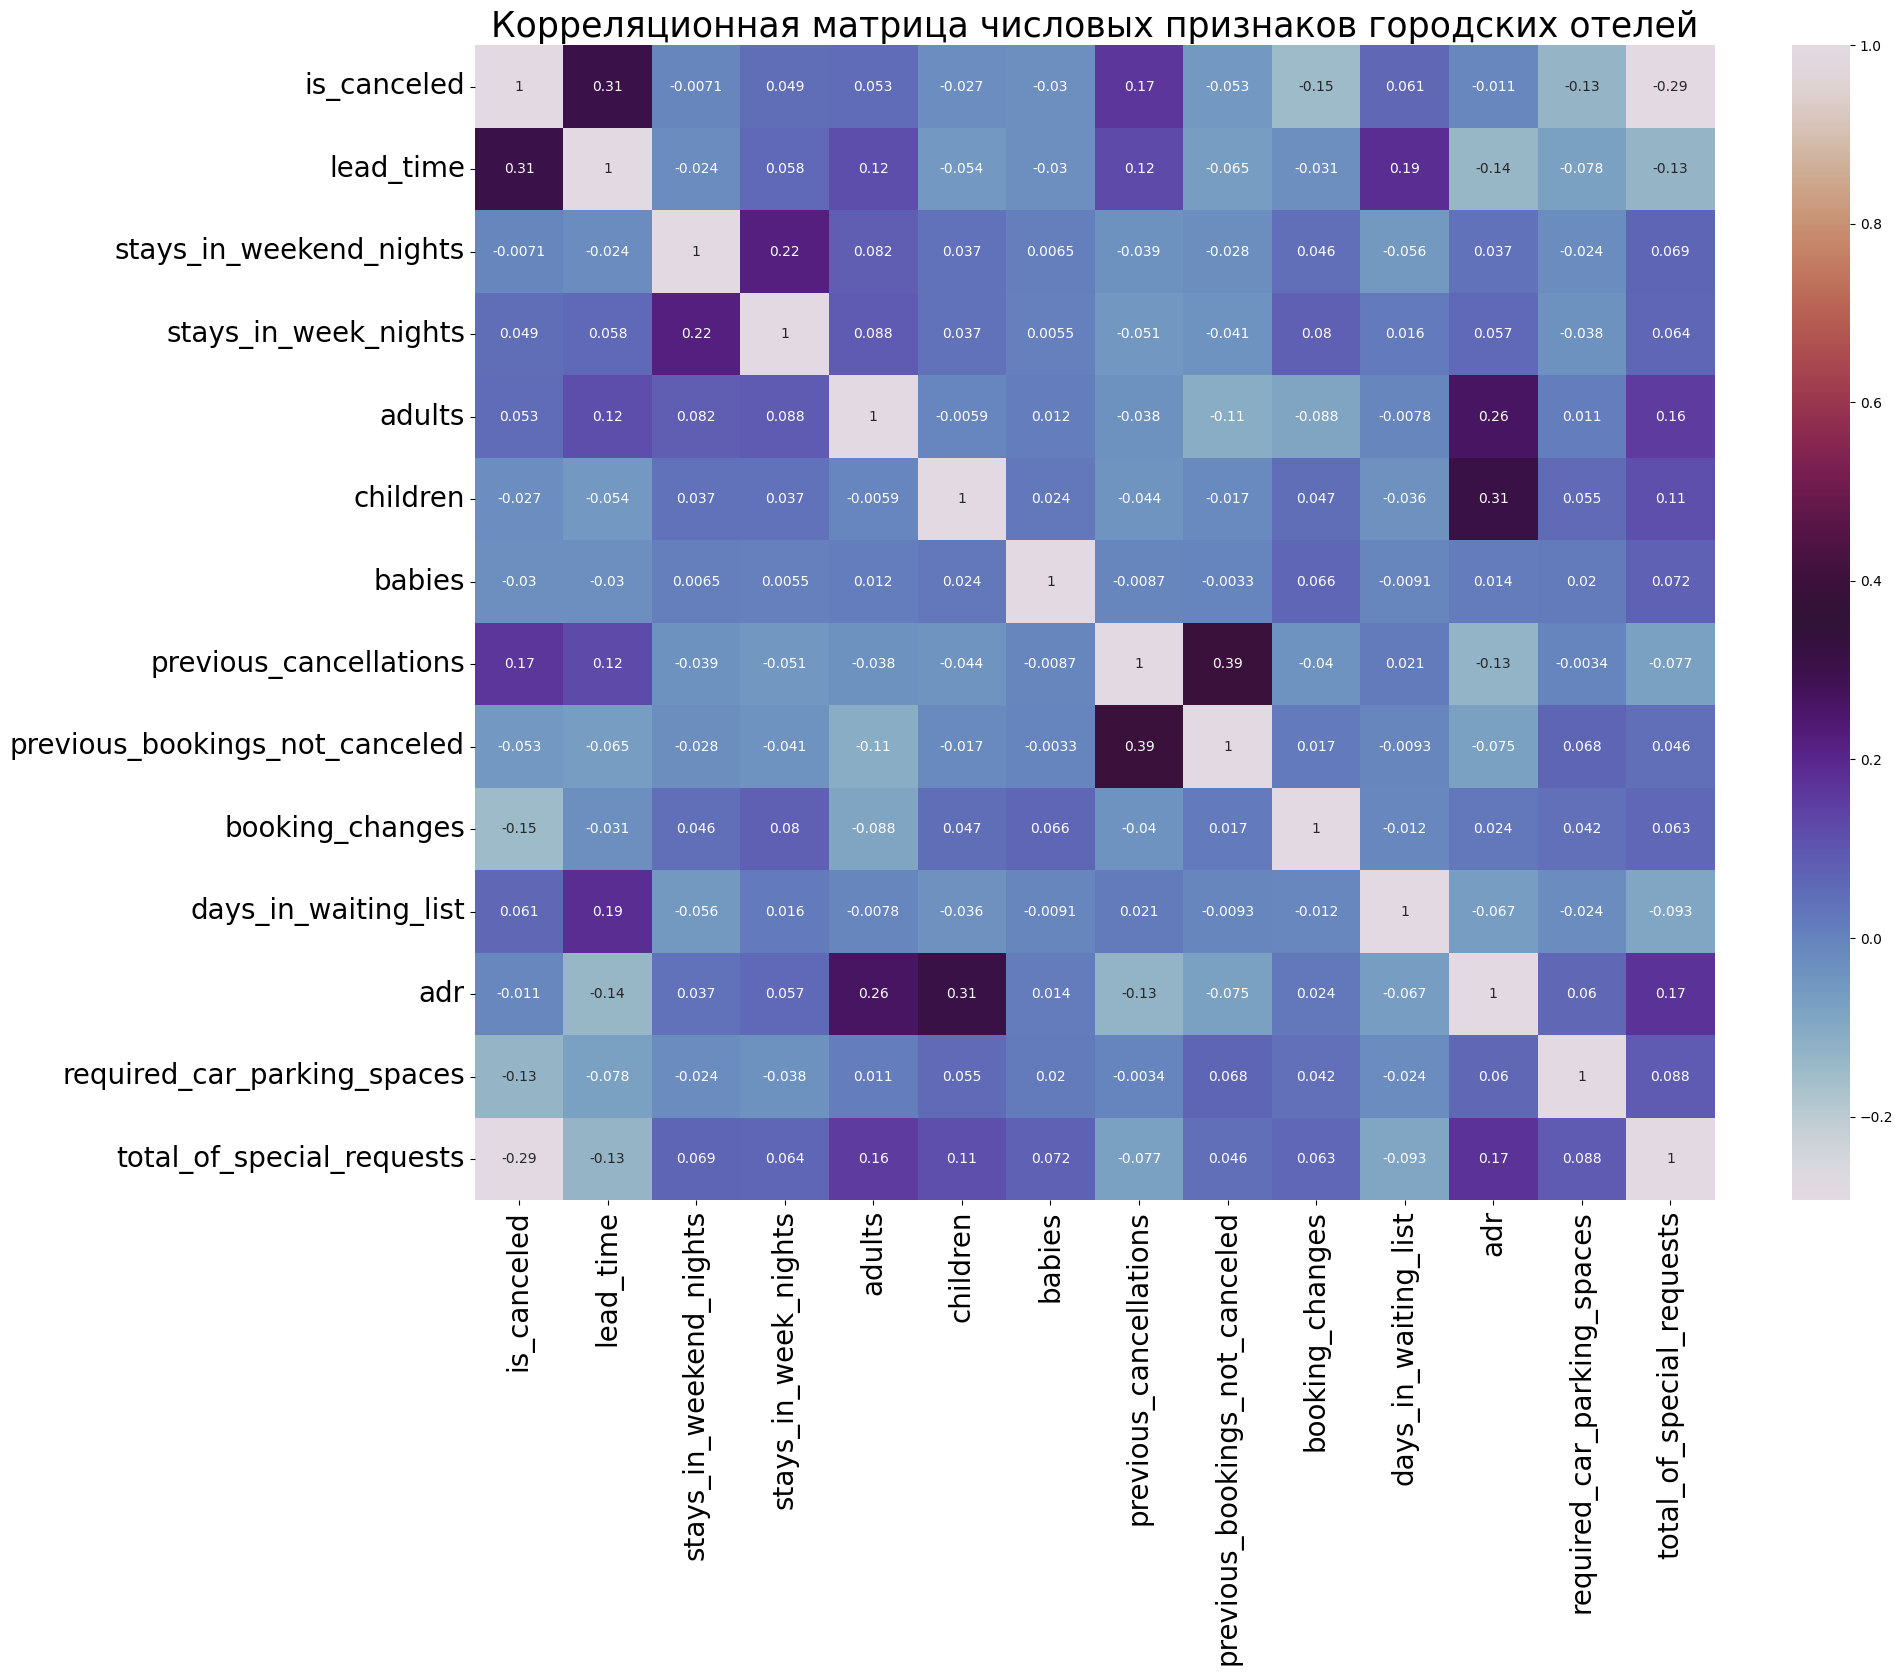

In [ ]:
numeric_city = city_subset[numeric_features]
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(numeric_city.corr(), annot=True,
                      cmap='twilight')
plt.title('Корреляционная матрица числовых признаков городских отелей', fontsize=25)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)
plt.show()

## 1.3. Основные выводы по EDA, выбор методов и метрик для оценки качества

1. Поскольку таргетная переменная - бинарная, то разумно в качестве **бейзлайна** использовать **логистическую регрессию** для бинарной классификации.
2. Несколько отдельных выводов про корреляцию фичей для линейной регрессии:
 * сильных корреляций с таргетом не наблюдается
 * между фичами друг с другом заметно коррелируют `stays_in_weekend_nights` и `stays_in_week_nights` (особенно для курортных отелей) (коэффициент корреляции Пирсона 0.71, формула дана ниже)
 $$
 r_{XY} = \frac{\sum_{i=1}^n (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^n (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^n (Y_i - \bar{Y})^2}}
 $$
3. Изначально планировалось, что в качестве обучающей выборки будут выступать данные за 2015-2016 год ([out-of-time](https://habr.com/ru/companies/glowbyte/articles/524150/) подход), однако, как было показано выше, у нас нет полных данных за 2015 и 2017 год, чтобы можно было этот алгоритм проводить корректно. По этой причине возьмем переменную "номер недели" как категориальную и попробуем предсказывать на ней.
4. Как было показано выше, в данных есть достаточно **много категориальных переменных**, что наводит на вопросы о наличии линейной зависимости таргета с фичами. Скорее всего, результаты будут лучше при использовании **моделей бустинга**: во-первых, они умеют работать с категориальными значениями, во-вторых, для них не надо удалять имеющиеся у нас пропуски.

В качестве показателей качества базово будут использованы следующие метрики:
* Accuracy:
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$
* Precision:
$$
Precision = \frac{TP}{TP + FP}
$$
* Recall:
$$
Recall = \frac{TP}{TP + FN}
$$
* F1-score:
$$
F1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}
$$
* AUC (Area Under the Curve, под кривой подразумевается ROC -  Receiver Operating Characteristic):
$$
AUC = \sum_{i=1}^{n-1} \frac{(FPR_{i+1} - FPR_i) \cdot (TPR_i + TPR_{i+1})}{2}
$$

# 2. Baseline: логистическая регрессия

## Логистическая регрессия в формулах

* линейная комбинация признаков
$$
z = w_0 + w_1 x_1 + \dots + w_n x_n = \mathbf{w}^T \mathbf{x}
$$

* логит-преобразование и получение вероятности
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

$$
\hat{y} = \begin{cases}
1, & \text{если } \sigma(z) \geq 0.5, \\
0, & \text{иначе}.
\end{cases}
$$

* функция потерь/кросс-энтропия (оценка разницы между двумя распределениями вероятности)
$$
\mathcal{L}(\mathbf{w}) = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\sigma(z_i)) + (1 - y_i) \log(1 - \sigma(z_i)) \right]
$$
* оптимизация: градиентный спуск (задача - минимизировать функцию потерь)
$$
\frac{\partial \mathcal{L}}{\partial w_j} = \frac{1}{N} \sum_{i=1}^N (\sigma(z_i) - y_i) x_{i,j}
$$
* обновление весов; а - размер шага
$$
w_j := w_j - \alpha \frac{\partial \mathcal{L}}{\partial w_j}
$$

## Feature-engineering: One-hot encoding

Сначала мы обучаем линейную модель. Для этого нам надо подать туда категориальные переменные в виде чисел, для чего подходит one-hot encoding.

In [ ]:
# все отели

# исключим ненужные колонки
hotel_dataset_prep = hotel_dataset.drop(columns=to_drop)

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(hotel_dataset_prep[cat_features])
one_hot_hd = pd.DataFrame(one_hot_encoded,
                          columns=encoder.get_feature_names_out(cat_features))

hotel_final_df = pd.concat([hotel_dataset_prep[numeric_features].reset_index(drop=True),
                            one_hot_hd.reset_index(drop=True)], axis=1)

print(hotel_final_df.shape)

(118902, 966)


In [ ]:
hotel_dataset_prep.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'agent', 'company',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

In [ ]:
# курортные отели

# исключим ненужные колонки
resort_prep = resort_subset.drop(columns=to_drop, errors='ignore')
cat_features_sub = cat_features.copy()
cat_features_sub.remove('hotel')

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(resort_prep[cat_features_sub])
one_hot_hd = pd.DataFrame(one_hot_encoded,
                          columns=encoder.get_feature_names_out(cat_features_sub))

resort_final_df = pd.concat([resort_prep[numeric_features].reset_index(drop=True),
                            one_hot_hd.reset_index(drop=True)], axis=1)

print(resort_final_df.shape)

(39596, 643)


In [ ]:
# фич значительно меньше в сравнении с остальным датасетом,
# на всякий случай посмотрим, что это за фичи; кажется, это то, что представлено
# в датасете с городом
a = set(hotel_final_df.columns)
b = set(resort_final_df.columns)
a.symmetric_difference(b)

{'agent_103.0',
 'agent_106.0',
 'agent_107.0',
 'agent_111.0',
 'agent_112.0',
 'agent_117.0',
 'agent_118.0',
 'agent_119.0',
 'agent_12.0',
 'agent_121.0',
 'agent_122.0',
 'agent_129.0',
 'agent_13.0',
 'agent_132.0',
 'agent_133.0',
 'agent_138.0',
 'agent_14.0',
 'agent_141.0',
 'agent_144.0',
 'agent_148.0',
 'agent_150.0',
 'agent_151.0',
 'agent_153.0',
 'agent_157.0',
 'agent_158.0',
 'agent_162.0',
 'agent_17.0',
 'agent_170.0',
 'agent_173.0',
 'agent_174.0',
 'agent_179.0',
 'agent_19.0',
 'agent_191.0',
 'agent_192.0',
 'agent_197.0',
 'agent_20.0',
 'agent_205.0',
 'agent_21.0',
 'agent_210.0',
 'agent_211.0',
 'agent_213.0',
 'agent_214.0',
 'agent_215.0',
 'agent_216.0',
 'agent_219.0',
 'agent_22.0',
 'agent_220.0',
 'agent_227.0',
 'agent_229.0',
 'agent_23.0',
 'agent_232.0',
 'agent_234.0',
 'agent_235.0',
 'agent_236.0',
 'agent_24.0',
 'agent_247.0',
 'agent_25.0',
 'agent_262.0',
 'agent_265.0',
 'agent_267.0',
 'agent_269.0',
 'agent_27.0',
 'agent_276.0',
 'ag

In [ ]:
# городские отели

# исключим ненужные колонки
city_prep = city_subset.drop(columns=to_drop, errors='ignore')

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(city_prep[cat_features_sub])
one_hot_hd = pd.DataFrame(one_hot_encoded,
                          columns=encoder.get_feature_names_out(cat_features_sub))

city_final_df = pd.concat([city_prep[numeric_features].reset_index(drop=True),
                            one_hot_hd.reset_index(drop=True)], axis=1)

print(city_final_df.shape)

(79306, 698)


## Логистическая регрессия без кросс-валидации

### Все отели

#### threshold=0.5

In [ ]:
X_hd = hotel_final_df.drop(columns='is_canceled')
y_hd = hotel_final_df['is_canceled']

X_train_hd, X_test_hd, y_train_hd, y_test_hd = train_test_split(X_hd, y_hd,
                                                                test_size=0.1,
                                                                random_state=random_num)

In [ ]:
# пайплайн + скалирование
logreg_baseline_hd = make_pipeline(StandardScaler(),LogisticRegression())
logreg_baseline_hd.fit(X_train_hd, y_train_hd)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
y_preds_hd = logreg_baseline_hd.predict(X_test_hd)
print(classification_report(y_test_hd, y_preds_hd))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      7473
           1       0.81      0.70      0.75      4418

    accuracy                           0.83     11891
   macro avg       0.82      0.80      0.81     11891
weighted avg       0.83      0.83      0.82     11891



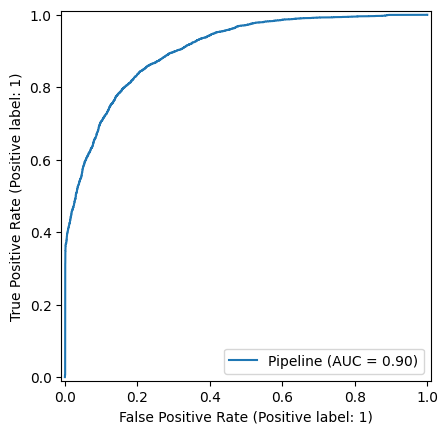

In [ ]:
RocCurveDisplay.from_estimator(logreg_baseline_hd, X_test_hd, y_test_hd)

#### threshold через оптимизацию ROC-AUC

В наших данных, как было замечено ранее, есть дисбаланс в таргетной переменной. Кроме того, иногда нам важно минимизировать конкретные типы ошибок (например, балансировать между FN/FP). Для этой цели стоит подбирать порог, при котором мы относим объект к тому или иному классу. В [статье](https://www.yourdatateacher.com/2021/06/14/are-you-still-using-0-5-as-a-threshold/) описано два подхода:
* оптимизация через ROC-AUC
* оптимизация через Accuracy

Последний пункт подходит для сбалансированных данных. Давайте применим ROC-AUC подход с учетом существующего дисбаланса классов.

In [ ]:
def optimize_threshold(X_train, y_train, X_test, y_test, model):
    fpr, tpr, thresholds = roc_curve(
    y_true=y_train,
    y_score=model.predict_proba(X_train)[:, 1],
    drop_intermediate=False)

    plt.scatter(thresholds,np.abs(fpr+tpr-1))
    plt.xlabel("Threshold")
    plt.ylabel("|FPR + TPR - 1|")
    plt.show()

    thres = thresholds[np.argmin(np.abs(fpr+tpr-1))]
    probas = model.predict_proba(X_test)[:,1]
    y_preds_thres = (probas >= thres).astype(int)
    print(classification_report(y_test, y_preds_thres))

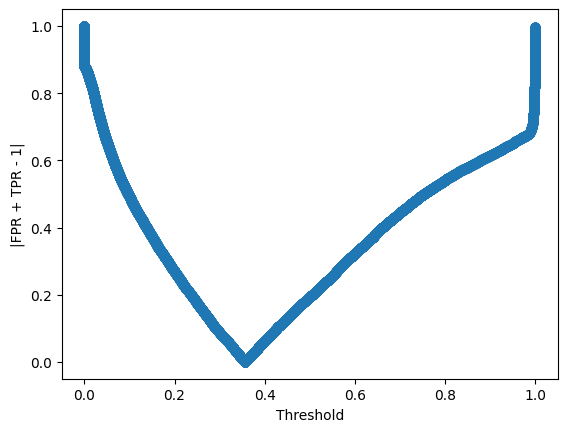

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      7473
           1       0.73      0.81      0.77      4418

    accuracy                           0.82     11891
   macro avg       0.80      0.82      0.81     11891
weighted avg       0.82      0.82      0.82     11891



In [ ]:
optimize_threshold(X_train_hd, y_train_hd, X_test_hd, y_test_hd,
                   logreg_baseline_hd)

Мы стали чуть лучше предсказывать непосредственно отмены.

#### Визуализация важности признаков

In [ ]:
# так как признаков у нас аж 900, визуализировать все не получится, достанем топ
def get_top_n_features(pipeline_trained, n):
    model = pipeline_trained.named_steps['logisticregression']

    viz = FeatureImportances(model, relative=False, stack=False, topn=n)
    viz.fit(X_train_hd, y_train_hd)

    # тут мы достаем топ по модулю
    coef = model.coef_[0]
    top_indices = np.argsort(np.abs(coef))[::-1][:n]

    viz.features_ = np.array(X_train_hd.columns)[top_indices]
    viz.importances_ = coef[top_indices]
    viz.show()

/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


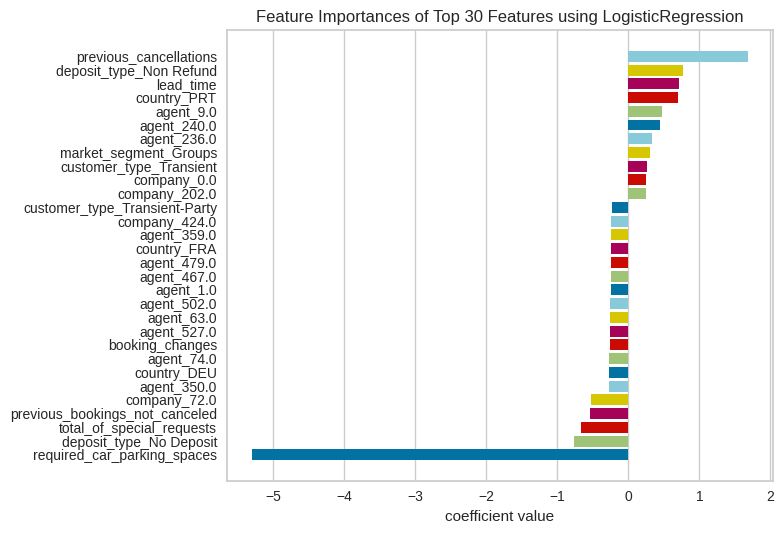

In [ ]:
get_top_n_features(logreg_baseline_hd, 30)

Как можно увидеть, наиболее важные признаки дляи логистической регрессии оказались числовые, что логично, учитывая ее линейную природу.

### Курортные отели

#### threshold=0.5

In [ ]:
X_resort = resort_final_df.drop(columns='is_canceled')
y_resort = resort_final_df['is_canceled']

X_train_resort, X_test_resort, \
y_train_resort, y_test_resort = train_test_split(X_resort,
                                                 y_resort,
                                                 test_size=0.1,
                                                 random_state=random_num)

In [ ]:
# пайплайн + скалирование
logreg_baseline_resort = make_pipeline(StandardScaler(),LogisticRegression())
logreg_baseline_resort.fit(X_train_resort, y_train_resort)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
y_preds = logreg_baseline_resort.predict(X_test_resort)
print(classification_report(y_test_resort, y_preds))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2826
           1       0.79      0.64      0.71      1134

    accuracy                           0.85      3960
   macro avg       0.83      0.79      0.80      3960
weighted avg       0.84      0.85      0.84      3960



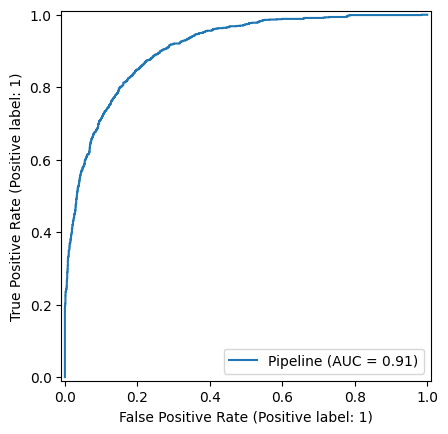

In [ ]:
RocCurveDisplay.from_estimator(logreg_baseline_resort, X_test_resort,
                               y_test_resort)

#### threshold через оптимизацию ROC-AUC


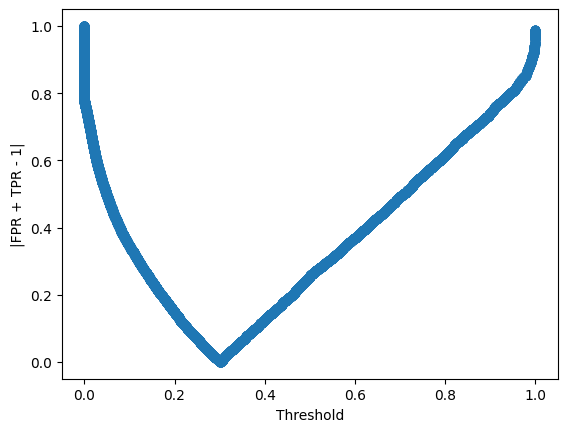

              precision    recall  f1-score   support

           0       0.91      0.84      0.88      2826
           1       0.67      0.80      0.73      1134

    accuracy                           0.83      3960
   macro avg       0.79      0.82      0.80      3960
weighted avg       0.84      0.83      0.83      3960



In [ ]:
optimize_threshold(X_train_resort, y_train_resort, X_test_resort, y_test_resort,
                   logreg_baseline_resort)

Опять же, лучше стали предсказывать отмены, но у нас упал precision.

#### Визуализация важности признаков

/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


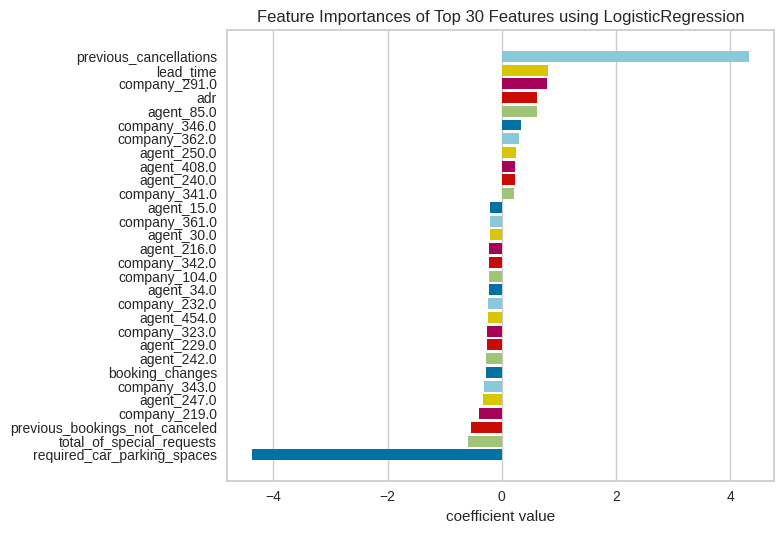

In [ ]:
get_top_n_features(logreg_baseline_resort, 30)

### Городские отели

#### threshold=0.5

In [ ]:
X_city = city_final_df.drop(columns='is_canceled')
y_city = city_final_df['is_canceled']

X_train_city, X_test_city, \
y_train_city, y_test_city = train_test_split(X_city,
                                             y_city,
                                             test_size=0.1,
                                             random_state=random_num)

In [ ]:
logreg_baseline_city = make_pipeline(StandardScaler(),LogisticRegression())
logreg_baseline_city.fit(X_train_city, y_train_city)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
y_preds = logreg_baseline_city.predict(X_test_city)
print(classification_report(y_test_city, y_preds))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      4613
           1       0.83      0.73      0.78      3318

    accuracy                           0.82      7931
   macro avg       0.82      0.81      0.82      7931
weighted avg       0.82      0.82      0.82      7931



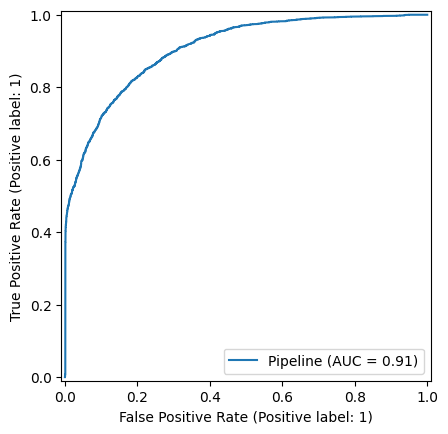

In [ ]:
RocCurveDisplay.from_estimator(logreg_baseline_city, X_test_city, y_test_city)

#### threshold через оптимизацию ROC-AUC

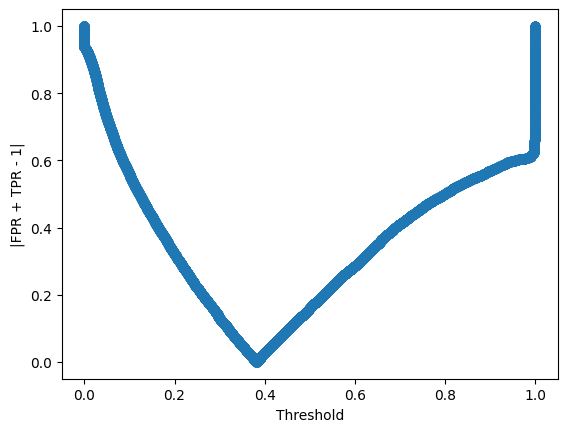

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4613
           1       0.76      0.82      0.79      3318

    accuracy                           0.82      7931
   macro avg       0.81      0.82      0.81      7931
weighted avg       0.82      0.82      0.82      7931



In [ ]:
optimize_threshold(X_train_city, y_train_city, X_test_city, y_test_city,
                   logreg_baseline_city)

Вот тут выросли метрики не только для отмен

#### Городские отели

/usr/local/lib/python3.11/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


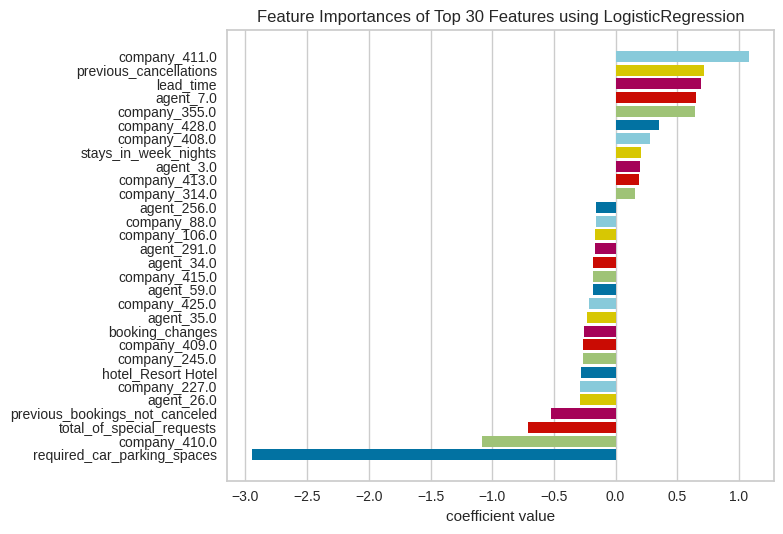

In [ ]:
get_top_n_features(logreg_baseline_city, 30)

А тут на первое место вышла уже компания!

К слову, для всех трех групп важным оказался признак "количество предыдущих отмен", что достаточно логично: если гость отменял до этого штуки, то отменит и дальше.

А вот большое значение количества забронированных машин (если много забронировали, то скорее всего не отменят бронь) говорит о том, что гость серьезно планирует поездку. Он молодец.

# Логистическая регрессия: кросс-валидация

Чтобы улучшить бейзлайн, попробуем провести кросс-валидацию для гиперпараметров логистической регрессии. Для этого используем фреймворк [optuna](https://habr.com/ru/companies/skillfactory/articles/900658/): он делает подбор гиперпараметров не настолько долго, как `GridSearchCV`, при этом умнее, чем `RandomSearchCV`. Он подбирает гиперпараметры, основываясь на [TPE](https://arxiv.org/pdf/1208.3719). Механика этого устроена следующим образом (тут небольшой пересказ [главы из учебника ШАДа](https://education.yandex.ru/handbook/ml/article/podbor-giperparametrov):
1. Сначала мы "разогреваем" модель, подбирая значения гиперпараметров и считая качество модели
2. Затем мы выбираем "хорошие" и "плохие" значения гиперпараметров и строим по ним оценки распределения: пусть l(x) - лучшие результаты, g(x) - худшие.
3. Далее высчитывается Expected Improvement (EI), на основе значения которой ищется "новая точка" для гиперпараметра. Наша задача - максимизировать попадание точки в распределение l(x) и минимизировать вероятность попадания в распределение g(x).
$$
EI(x) = \frac{l(x)}{g(x)}
$$
4. С каждой новой итерацией мы обновляем значения распределений и ищем значения гиперпараметра заново.

У нас во всех случаях не то что сильно высокая accuracy. Давайте попробуем ее максимизировать. Подбирать будем следующие гиперпараметры (**жирным** выделены дефолтные значения):
* `C`: сила регуляризации (для избежания переобучения) (дефолт - **`1.0`**)
* `penalty`: тип регуляризации (`l1`, **`l2`**, `elasticnet`, `None`)
* `l1-ratio`: если регуляризация - `elasticnet`, то соотношение l1/l2 регуляризации
* `solver`: алгоритм оптимизации (`newton-cg`, **`lbfgs`**, `liblinear`, `sag`, `saga`)
* `max_iter`
* `tol`
* `class_weight`
* `fit_intercept`

In [ ]:
def multi_objective(trial, X, y):
    # предлагаем значение для C
    logreg_c = trial.suggest_float("logreg_c", 1e-5, 1e2, log=True)

    # Создаем модель
    model = LogisticRegression(C=logreg_c,
                               max_iter=1000,
                               solver='liblinear')

    # Оцениваем точность (accuracy)
    score = sklearn.model_selection.cross_val_score(model, X, y, n_jobs=-1, cv=3)
    accuracy = score.mean()

    # Наша вторая цель - минимизировать C (или его логарифм для стабильности)
    # Чем меньше C, тем проще модель (сильнее регуляризация)
    complexity_proxy = np.log(logreg_c) # Минимизируем логарифм C

    # Возвращаем КОРТЕЖ из двух значений: (accuracy, complexity_proxy)
    return accuracy, complexity_proxy

# 3. Создаем исследование с ДВУМЯ целями
# Первая цель - accuracy (maximize), вторая - complexity_proxy (minimize)
study_multi = optuna.create_study(directions=["maximize", "minimize"])

# 4. Запускаем оптимизацию
study_multi.optimize(multi_objective, n_trials=100)

print("Количество завершенных испытаний: ", len(study_multi.trials))
print("Парето-оптимальные испытания:")

for trial in study_multi.best_trials:
    print("  Испытание номер:", trial.number)
    print("    Значения целей (accuracy, log(C)): ", trial.values)
    print("    Гиперпараметры: ", trial.params)
    print("-" * 20)

[I 2025-06-08 11:27:25,950] A new study created in memory with name: no-name-4192624d-0f67-40ea-be9e-970d830120d2
[I 2025-06-08 11:27:33,792] Trial 0 finished with values: [0.9266666666666666, -0.8787274069483342] and parameters: {'logreg_c': 0.41531109754448386}.
[I 2025-06-08 11:27:33,828] Trial 1 finished with values: [0.64, -6.367936199176674] and parameters: {'logreg_c': 0.0017156964299721007}.
[I 2025-06-08 11:27:33,876] Trial 2 finished with values: [0.96, 0.191712009285169] and parameters: {'logreg_c': 1.2113216173489165}.
[I 2025-06-08 11:27:33,920] Trial 3 finished with values: [0.8466666666666667, -1.8673139843971622] and parameters: {'logreg_c': 0.15453819685009118}.
[I 2025-06-08 11:27:33,952] Trial 4 finished with values: [0.6066666666666668, -6.401473109836778] and parameters: {'logreg_c': 0.0016591114187588536}.
[I 2025-06-08 11:27:33,997] Trial 5 finished with values: [0.6666666666666666, -5.0639633632020855] and parameters: {'logreg_c': 0.006320459528871948}.
[I 2025-

Количество завершенных испытаний:  100
Парето-оптимальные испытания:
  Испытание номер: 1
    Значения целей (accuracy, log(C)):  [0.64, -6.367936199176674]
    Гиперпараметры:  {'logreg_c': 0.0017156964299721007}
--------------------
  Испытание номер: 2
    Значения целей (accuracy, log(C)):  [0.96, 0.191712009285169]
    Гиперпараметры:  {'logreg_c': 1.2113216173489165}
--------------------
  Испытание номер: 3
    Значения целей (accuracy, log(C)):  [0.8466666666666667, -1.8673139843971622]
    Гиперпараметры:  {'logreg_c': 0.15453819685009118}
--------------------
  Испытание номер: 4
    Значения целей (accuracy, log(C)):  [0.6066666666666668, -6.401473109836778]
    Гиперпараметры:  {'logreg_c': 0.0016591114187588536}
--------------------
  Испытание номер: 12
    Значения целей (accuracy, log(C)):  [0.8866666666666667, -1.5040522042294207]
    Гиперпараметры:  {'logreg_c': 0.2222278206364863}
--------------------
  Испытание номер: 15
    Значения целей (accuracy, log(C)):  [0.

# Бустинг